# HDBSCAN Clustering and Prediction Mode

It’s helpful to train a model on a large dataset and then query it repeatedly with new smaller volumes of data. 

HDBSCAN can predict in the following manner. New data points would normally change the clustering as new datapoints would create, split, and merge previous clusters. HDBSCAN navigates this by holding a clustering fixed. Therefore, this question can be answered: **“if we add new data to existing clusters which cluster will HDBSCAN assign the new points to?”** 

After the potentially expensive training run, this prediction is computationally inexpensive.

In [1]:
''' HDBSCAN Experimentation on 1 months data ''' 

import pandas as pd
import glob
import os
import numpy as np
from sklearn.model_selection import train_test_split

#(1) combine 36 months of crime data 09/2018 - 08/2021

path = r'C:\Users\pigle\OneDrive\Documents\Business Analytics\MSc Project\Raw_Data_allYears' # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))  # use os.path.join as this makes concatenation OS independent
df_from_each_file = (pd.read_csv(f) for f in all_files)
df   = pd.concat(df_from_each_file, ignore_index=True) # doesn't create a list, nor does it append to one
#df.to_excel('combined_file.xlsx')
df.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,NaN,2018-09,Merseyside Police,Merseyside Police,-2.711600,53.383635,On or near Camberwell Park Road,E01012392,Halton 001A,Anti-social behaviour,NaN,NaN
1,0111ce2b17f7bb96f29fe70a7a06afd1490eb05f3c8683...,2018-09,Merseyside Police,Merseyside Police,-2.747770,53.389499,On or near Cronton Road,E01012393,Halton 001B,Vehicle crime,Unable to prosecute suspect,NaN
2,NaN,2018-09,Merseyside Police,Merseyside Police,-2.849802,53.490299,On or near Depot Road,E01006448,Knowsley 001A,Anti-social behaviour,NaN,NaN
3,NaN,2018-09,Merseyside Police,Merseyside Police,-2.872402,53.484743,On or near Quarryside Drive,E01006448,Knowsley 001A,Anti-social behaviour,NaN,NaN
4,NaN,2018-09,Merseyside Police,Merseyside Police,-2.870599,53.485736,On or near Darmond Road,E01006448,Knowsley 001A,Anti-social behaviour,NaN,NaN


Text(0.5, 1.0, 'Crime Scatterplot 09-2018 ')

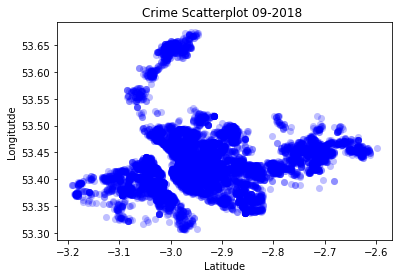

In [2]:
#(2) HDDBSCAN

import matplotlib.pyplot as plt
import seaborn as sns 
import hdbscan
%matplotlib inline
## clean and transform data for spatial clustering
coords = df.loc[:,['Latitude', 'Longitude','Month']] 
coords2 = coords[coords['Month'] == '2018-09']
coords2= coords2.drop(columns=['Month'])
coords2=coords2[['Longitude','Latitude']]
coords_array = coords2[['Longitude','Latitude']].to_numpy()
x_train ,x_test = train_test_split(coords_array,test_size=0.01)
x_train_df = pd.DataFrame(x_train)
x_train_df.head()

plt.scatter(*x_train.T, s=50, linewidths=0, c='b', alpha=0.25)
plt.xlabel('Latitude')            
plt.ylabel('Longitutde')
plt.title('Crime Scatterplot 09-2018 ')

A scatterplot shows the fullest distribution of offences across Merseyside and how impractical it is for focusing on crime dense regions.

Number of Clusters: 39


Text(0.5, 1.0, 'HDBSCAN 09-2018')

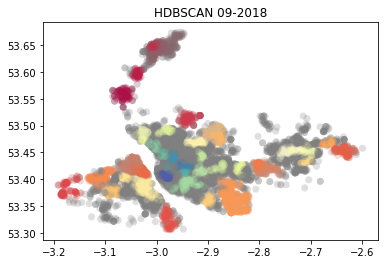

In [6]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=60, min_samples=15, prediction_data=True).fit(x_train)
clusters= np.asarray(clusterer.labels_)
clusterer.labels_
print('Number of Clusters:', clusterer.labels_.max())
clusterer.probabilities_

color_palette = sns.color_palette('Spectral', 40)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*x_train.T, s=50, linewidths=0, c=cluster_member_colors, alpha=0.25)
plt.title('HDBSCAN 09-2018')

13,383 points reduced to 39 clusters, 99/1 train/test split, test set = 136 points.

First, HDBSCAN has automatically formed the number of clusters using the density of the crime’s location datapoints, reduced its scale, enabled varying cluster density, and discovered clusters with arbitrary shapes such as linear, oval etc. Clearly recognisable **colours depict the 30+ crime clusters** whilst the **grey tones represent noise that is ignored**.

Second, the **parameters for HDBSCAN are highly accessible**, police can intuitively decide what the minimum size of crime point groupings is, to be considered a cluster. The **granularity of the represented data can be easily  tweaked** based on police needs and this is demonstrated later in the Ensemble method.

Text(0.5, 1.0, 'HDBSCAN New Datapoint Cluster Predictions 09-2018')

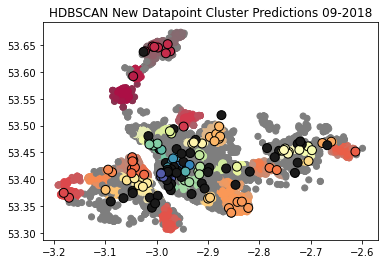

In [4]:
## originally generated random points to test, decided train/test-split would be better test
#test_points = np.random.uniform(low=53.2989, high=53.55, size=(50,)), np.random.uniform(low=-3.19223, high=-2.59898, size=(50,))
#Test = np.asarray(test_points)     
#Test1=Test.transpose() 

#(3) HDBSCAN prediction tasks

colors = [sns.desaturate(color_palette[col], sat) for col, sat in zip(clusterer.labels_,
                                                            clusterer.probabilities_)]
plt.scatter(*x_train.T, s=50, linewidths=0, c=cluster_member_colors, alpha=0.25)
plt.scatter(*x_test.T, c='k', s=50)
test_labels, strengths = hdbscan.approximate_predict(clusterer, x_test)
test_labels
colors = [sns.desaturate(color_palette[col], sat) for col, sat in zip(clusterer.labels_,
                                                            clusterer.probabilities_)]
test_colors = [color_palette[col] if col >= 0 else (0.1, 0.1, 0.1) for col in test_labels]
plt.scatter(x_train.T[0], x_train.T[1], c=colors);
plt.scatter(*x_test.T, c=test_colors, s=80, linewidths=1, edgecolors='k')
plt.title('HDBSCAN New Datapoint Cluster Predictions 09-2018')

The **black circles** represent new datapoints not assigned to existing clusters and the **coloured circles with black borders** are new datapoints adhering to clusters. 

So the **predictive function is useful for testing if new crime data adheres to existing dense crime regions**. It’s also beneficial for evaluating if subsets of crime data are consistent with another subset , hence it confirms generalisation of the model and earlier pre-processing

It must be noted that clustering is unlabelled and not a classification type of machine learning. As there is no labelled training data for clustering it fundamentally predicts without learning but for the above purposes (not classification) it’s not problematic.